In [ ]:
!pip install kaggle

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import os
from PIL import Image, ImageFilter
import cv2

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


下載資料集


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c cidaut-ai-fake-scene-classification-2024

 97% 137M/141M [00:01<00:00, 109MB/s] 
100% 141M/141M [00:01<00:00, 84.9MB/s]


In [ ]:
!unzip cidaut-ai-fake-scene-classification-2024.zip -d '/content/drive/My Drive/2024_kaggle/'

Archive:  cidaut-ai-fake-scene-classification-2024.zip
  inflating: /content/drive/My Drive/2024_kaggle/Test/102.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/108.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/109.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/111.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/121.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/122.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/126.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/127.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/130.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/133.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/134.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/135.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/137.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/Test/139.jpg  
  inflating: /content/drive/My Drive/2024_kaggle/

# train dataset

In [ ]:
# 讀取 CSV 檔
csv_path = '/content/drive/My Drive/2024_kaggle/train.csv'
train_image = '/content/drive/My Drive/2024_kaggle/Train'

data = pd.read_csv(csv_path)

# 創建 train data 目錄
base_path = "/content/drive/My Drive/2024_kaggle/train_data"
real_path = os.path.join(base_path, "real")
editada_path = os.path.join(base_path, "editada")

if not os.path.exists(real_path):
    os.makedirs(real_path)
if not os.path.exists(editada_path):
    os.makedirs(editada_path)

# 將圖片分發到 train_data/real 和 train_data/editada 目錄中
for i in zip(data['image'], data['label'], range(len(data['image']))):
    image = Image.open(f"/content/drive/My Drive/2024_kaggle/Train/{i[0]}")

    if i[1] == 'editada':  # 'editada' -> label 0
      try:
        image.filter(ImageFilter.EDGE_ENHANCE_MORE).save(f"/content/drive/My Drive/2024_kaggle/train_data/editada/{i[0]}")
      except Exception as e:
        print(e)
    elif i[1] == 'real':  # 'real' -> label 1
      try:
        image.filter(ImageFilter.EDGE_ENHANCE_MORE).save(f"/content/drive/My Drive/2024_kaggle/train_data/real/{i[0]}")
      except Exception as e:
        print(e)


KeyboardInterrupt: 

# test dataset

In [ ]:
test_image = os.listdir("/content/drive/My Drive/2024_kaggle/Test")

 # 創建 test date 目錄
if not os.path.exists(f"/content/drive/My Drive/2024_kaggle/test_data"):
    os.mkdir(f"/content/drive/My Drive/2024_kaggle/test_data")

 # 將圖片轉移到test_data目錄中
for i in test_image:
    image = Image.open(f"/content/drive/My Drive/2024_kaggle/Test/{i}")
    try:
      image.filter(filter=ImageFilter.EDGE_ENHANCE_MORE).save(f"/content/drive/My Drive/2024_kaggle/test_data/{i}")
    except Exception as e:
      print(e)

# Data Setup

In [16]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 16

# 拆分100個trainset的圖片作為驗證
# train:620張圖片 / test:100張圖片
trainset = torchvision.datasets.ImageFolder(root=f'./train_data/', transform=transform_train)   # 會自動幫子資料夾中的圖片標籤(0,1)，站照字母順序(editada 的字母順序在real之前，因此：editada:0  real:1)
train, valid = torch.utils.data.random_split(trainset, [len(trainset)-100,100])

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size,shuffle=True, num_workers=2)

# 印出部分圖片與label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


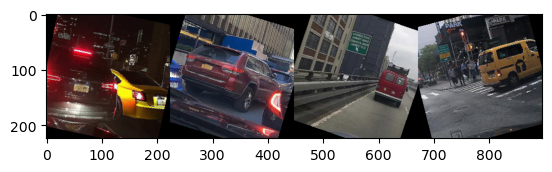

Class labels:  real  real  real  editada


In [17]:
import numpy as np

classes = ('real', 'editada')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images and rotated images
imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [18]:
torch.cuda.empty_cache()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

device = torch.device('cuda')
device

device(type='cuda')